# Astrometry Response Functions (Maps)

This notebook generates a visual representation for the **analytical results** of $H_{ij}^{(0)}, H_{ij}^{(1)}$ and $K_{i}^{(0)}, K_{i}^{(1)}$ shown in 2412.14010


In [1]:
import numpy as np
import jax.numpy as jnp #This package makes faster vector calculations
from jax import vmap, grad
import matplotlib
from matplotlib import colormaps
import matplotlib.pyplot as plt
import healpy as hp
import itertools
import os

We use **Mollview** (from healpy), which gives us a Mollweide projection with a given numpy array. In Mollview, the standard coordinates are **spherical** with the co-latitude $\theta \in [0,\pi]$ (North pole to South pole),  and the longitude $\phi \in [0, 2\pi]$ eastward. For the projection, $\phi = 0$ is at the center, increasing eastward towards the map's left.

In this notebook, we will use the Galactic coordinates $(l,b)$; $b$ is related to the co-latitude $\theta$ as $\theta = \pi/2 -b$, whereas the longitude $\phi$ remains the same as $l$.

## Some important asumptions
$\bf v$ is our velocity with respect to the cosmic frame. In galactic coordinates, its direction is along $(l,b)=(264^{\circ},48^{\circ})$, or in equatorial coordinates $(\mathrm{RA}, \mathrm{De})=(167.78^{\circ}, -7.145^{\circ})$. According to CMB observations $\beta = v/c\,=\,1.23\times 10^{-3}$.

In [2]:
# Conversion between b and \theta
v_theta = (np.pi/2)-np.radians(48) # (pi/2 - b) E[0,pi]
v_phi = np.radians(264) # l E[0,2pi]

In [3]:
# We define the 'skyvec' function as giving us a unit vector in R3. 
# Given two angles, \theta E[0,pi] and \phi E[0,2pi], 'skyvec' returns its cartesian coordinates
def skyvec(theta,phi): 
    st = np.sin(theta)
    cp = np.cos(phi)
    sp = np.sin(phi)
    ct = np.cos(theta)
    return np.array([st*cp,st*sp,ct])

#print(skyvec(2,3)) # Uncomment to test the function defined above.
#print(np.dot(skyvec(2,3),skyvec(2,3)))

In the next cell, the functions $\mathrm{Tr}[\mathbf{H}_0 \mathbf{H}_0]$, $\mathrm{Tr}[\mathbf{H}_1 \mathbf{H}_1]$ and $\mathbf{K}_{0} \mathbf{K}_{0}^{T}$, $\mathbf{K}_{1} \mathbf{K}_{1}^{T}$ are defined.

In [4]:
def vecdot(a,b): # dot product for (N,3) vectors
    a = np.atleast_2d(a)
    b = np.atleast_2d(b)
    dot = np.sum(a*b,axis=1)
    return dot

# ------------ Uncomment if a test to the 'vecdot' function is needed. ------- 
#a =np.array([[0,1,2],[3,4,5],[6,7,8],[9,10,11]]).reshape(4,3)
#b =np.array([[0,1,1]])#.reshape(3,1)
#adotb = vecdot(a,b)
#print('Dot:',adotb)
#print(np.cross([3,4,5],[0,1,1]))
# ----------------------------------------------------------------------------

def Hmonopole_analytical(xvec,nvec):
    ndotx = vecdot(xvec,nvec)
    H0H0 = ((1 + ndotx**2) * np.pi**2 * (5 - 2*ndotx - 7*ndotx**2 + 
          6*((ndotx - 1)**2)*np.log( (1 - ndotx)/2) )**2) / (9 * (1 + ndotx)**2)
    return H0H0

def Hdipole_analytical(nvec, xvec, vcrossn):
    ndotx = jnp.sum(nvec*xvec) #vecdot(xvec,nvec)
    Adotv = jnp.sum(xvec*vcrossn) #vecdot(xvec,vcrossn)
    H1H1= (1 / (9 * (1 + ndotx)**2)) * 4 * np.pi**2 * (
          (1 + ndotx) * ((-2 + ndotx)**2 * (ndotx - 1)**4 * (1 + ndotx) - 
          Adotv**2 * (4 + (ndotx - 1) * ndotx * (8 + ndotx * (15 + (ndotx * (ndotx - 6)))))) + 
          6 * (ndotx - 1)**2 * ((-2 + ndotx) * (ndotx - 1)**3 * (1 + ndotx) + 
          Adotv**2 * (-2 + ndotx + 4 * ndotx**2 - ndotx**3)) * jnp.log((1 - ndotx) / 2) + 
          9 * (ndotx - 1)**4 * (-1 - Adotv + ndotx) * (-1 + Adotv + ndotx) * jnp.log((1 - ndotx) / 2)**2)
    return H1H1

def K0_analytical(nvec, xvec):
    ndotx = jnp.sum(nvec*xvec)
    y = (1- ndotx)/2
    K0K0= -((256 * np.pi**2 * y**2 * (2 - 2*y + 3*y*jnp.log(y))**2) / 
           (9 * (-1 + ndotx**2)))
    return K0K0

def K1K1_analytical(nvec, xvec, vvec):
    ndotx = jnp.sum(nvec*xvec)
    ndotv = jnp.sum(nvec*vvec)
    vdotx = jnp.sum(vvec*xvec)
    A1 = jnp.cross(nvec, xvec) 
    A1dotV = jnp.sum(A1*vvec)
    K1K1 = (1 / (9 * (1 + ndotx)**4 * (A1dotV - A1dotV * ndotx)**2)) * \
       4 * (-1 + ndotx**2) * np.pi**2 * (
           ((1 + ndotx)**2 * 
            (-A1dotV**4 * (5 - 6 * ndotx)**2 + 
             (ndotv * (4 + ndotx * (-7 + 2 * ndotx)) + 
              (4 + 3 * (-2 + ndotx) * ndotx) * vdotx)**2 * 
             (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2))) + 
           12 * jnp.log((1 - ndotx) / 2) * (
               (-1 + ndotx)**2 * (1 + ndotx) * 
               (A1dotV**4 * (-5 + 6 * ndotx) + 
                (ndotv + vdotx) * (ndotv * (4 + ndotx * (-7 + 2 * ndotx)) + 
                             (4 + 3 * (-2 + ndotx) * ndotx) * vdotx) * 
                (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2)) + 
               3 * (-1 + ndotx)**4 * 
               (-A1dotV**4 + (ndotv + vdotx)**2 * 
                (-1 + ndotv**2 + ndotx**2 - 2 * ndotv * ndotx * vdotx + vdotx**2)) * 
               jnp.log((1 - ndotx) / 2)
           )
       )
    return K1K1


def K1K1_analytical_Vparallel(nvec, xvec, vvec):
    ndotx = jnp.sum(nvec*xvec)
    ndotv = jnp.sum(nvec*vvec)
    z = (1-ndotx)/2
    term1 = 2*np.pi*(nvec*(1 - 2*z) - xvec)/ (3* (1 - z))
    term2 = ((z - 1)*(6*z + 1) - 6*z*jnp.log(z))
    K1i = term1*term2
    K1K1 = jnp.sum(K1i*K1i)
    return K1K1

In [5]:
# We generate a random unit vector for some of the cases in the maps
np.random.seed(5)
random_vector = np.random.randn(3)
unit_vector = random_vector / np.linalg.norm(random_vector)

#print(unit_vector)
#print(np.dot(unit_vector,unit_vector))

## Plotting Maps

The functions defined above need three vectors to be evaluated: $\bf n$, $\bf v$ and $\bf n'$. We will fixed the velocity with the direction mentioned earlier and will choose different directions for $\bf n'$, whilst for $\bf n$ we will take the coordinates of each of the pixels in the Map. 

#### Take into account:
As it was mentioned, Mollview will plot a map with a numpy array given. Each element of the array will refer to a location in the sky as defined by the Healpix pixelization schemes (https://healpix.jpl.nasa.gov). 

In the next cell, we define all of the vectors needed to get the values for the functions we are interested in. The function **map_stars_K0K0** is the numpy array that will be plotted, we calculated it with **vmap** from jax (see more https://docs.jax.dev/en/latest/_autosummary/jax.vmap.html).

The resolution of the map is defined by the **nside** parameter, it is related with the number of pixels by $N_{\mathrm{pix}}= 12\times N_{\mathrm{side}}^2$ (the higher the number of pixels are, the better the resolution is). $N_{\mathrm{side}}$ parameter is generally a power of 2. To obtain the directions of each pixel we use **hp.pix2vec**.

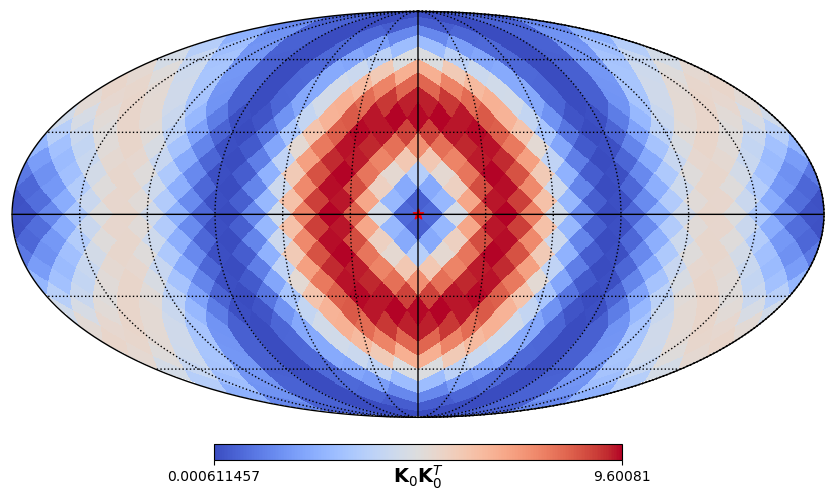

In [6]:
######### n' direction #########
nside_stars = 8 # This gives us 768 pixels (stars or pulsars in this case) for the map .
nstars = hp.nside2npix(nside_stars)
stars_idx = np.arange(nstars) # This returns evenly spaced values within nstars interval.
stars_vec = np.array(hp.pix2vec(nside_stars,stars_idx)).T  # Gets vectors from the pixels 
#------------------------------

######### n direction #########
theta1, phi1 = (np.pi/2, 0)
n1 = skyvec(theta1,phi1)#.reshape(3,1)
#------------------------------

######### v direction #########
v = skyvec(v_theta, v_phi)#.reshape(3,1)

#print('v shape:',np.shape(v))
#print('v:', v)
#------------------------------

f = lambda q: K0_analytical(n1, q)
map_stars_K0K0 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)

hp.mollview(map_stars_K0K0,title=r'',cmap='coolwarm',cbar=True, unit=r'$\mathbf{K}_{0} \mathbf{K}_{0}^{T}$')
hp.projscatter(theta1, phi1,marker='*',s=60,color='r')
hp.graticule()

#min = np.min(Map_TraceHij_1)
#max = np.max(Map_TraceHij_1)
#print('min:',min)
#print('max:',max)

So far, the resolution of the map is poor, but the pixels are enough for the calculations. We upgrade the resolution of the map in the next cell.

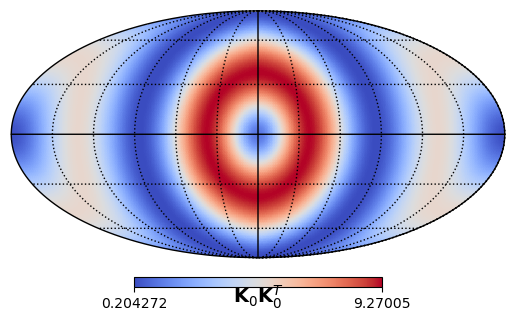

In [14]:
sm = map_stars_K0K0

fwhm = 0.2
up_map = hp.ud_grade(map_stars_K0K0,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True,title="",hold=True, unit=r'$\mathbf{K}_{0} \mathbf{K}_{0}^{T}$')
hp.graticule(color='k')

## Trying different values for $n$

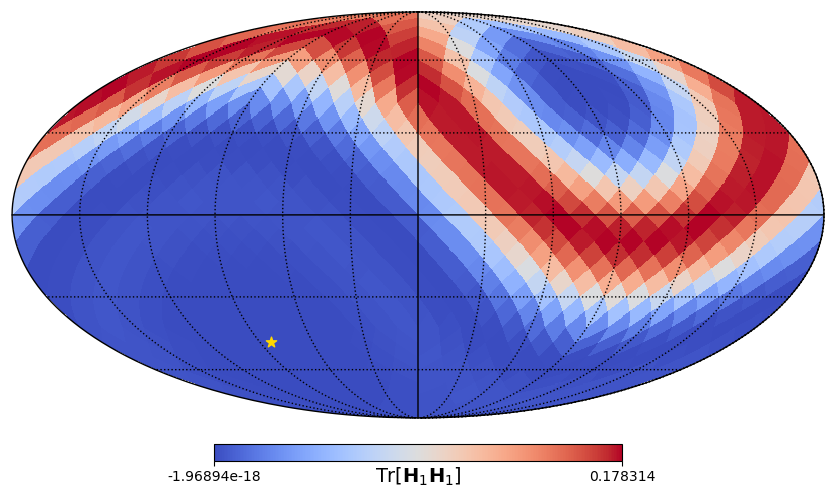

In [12]:
#n2 = jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
#n2 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
n2 = -v # Parallel to V
vcrossn = jnp.array(jnp.cross(v,n2))

theta_n2, phi_n2 = hp.vec2ang(n2)


f = lambda q: Hdipole_analytical(n2, q, vcrossn)
Map_H1H1 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)

hp.mollview(Map_H1H1, title=r'', cmap='coolwarm', cbar=True, unit=r'$\mathrm{Tr}[\mathbf{H}_1 \mathbf{H}_1]$')
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule()

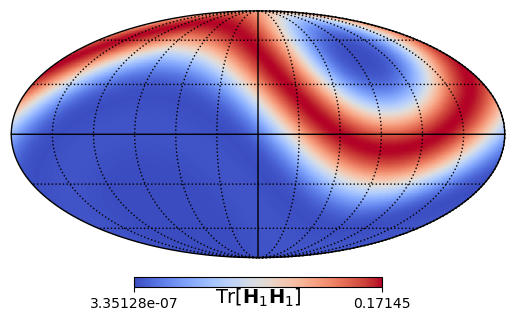

In [13]:
sm = Map_H1H1

fwhm = 0.2
up_map = hp.ud_grade(Map_H1H1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True,title="",hold=True, unit=r'$\mathrm{Tr}[\mathbf{H}_1 \mathbf{H}_1]$')
hp.graticule(color='k')

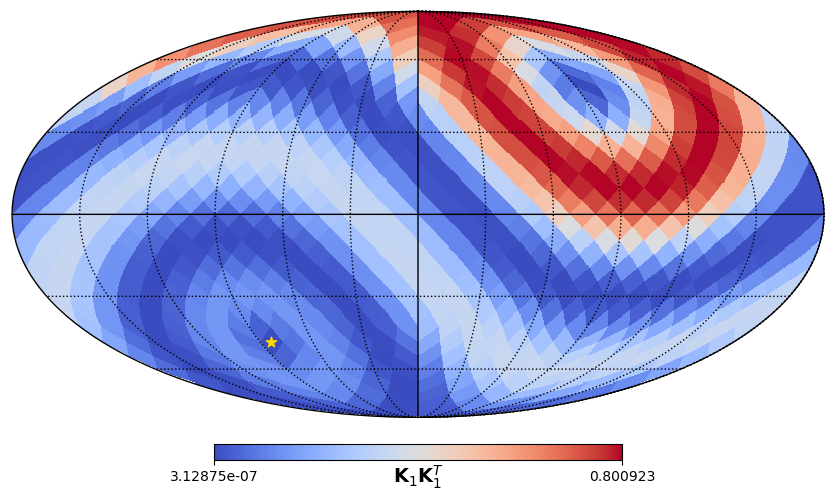

In [15]:
#n2 = jnp.array([-0.18639486, -0.72313051, -0.66508587]) # Orthogonal to V
#n2 = jnp.array([0.96388439, -0.26566278, 0.01871302]) # Random position in the Sky (close to the centre)
n2 = -v # Parallel to V

theta_n2, phi_n2 = hp.vec2ang(n2)


f = lambda q: K1K1_analytical_Vparallel(n2, q, v) # Caso paralelo a V
#f = lambda q: K1K1_analytical(n2, q, v)
Map_K1K1 = vmap(f, in_axes=(0),out_axes=(-1))(stars_vec)


hp.mollview(Map_K1K1, title=r'', cmap='coolwarm', cbar=True, unit=r'$\mathbf{K}_{1} \mathbf{K}_{1}^{T}$')
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule()


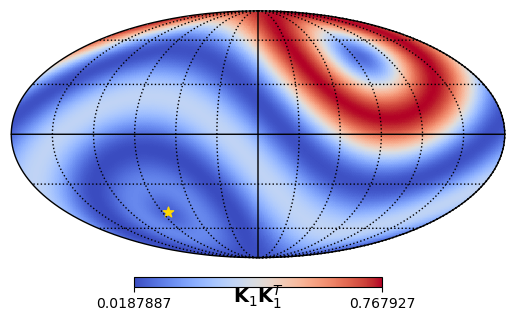

In [18]:
sm = Map_K1K1

fwhm = 0.2
up_map = hp.ud_grade(Map_K1K1,nside_out=128)
sm = hp.smoothing(up_map,fwhm=fwhm)

hp.mollview(sm,cmap='coolwarm',cbar=True ,title="", hold=True, unit=r'$\mathbf{K}_{1} \mathbf{K}_{1}^{T}$')
hp.projscatter(theta_n2, phi_n2, marker='*',s=60,color='gold')
hp.graticule(color='k')